# Example: Studyforrest

In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

import networkx as nx

import dyneusr as ds

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")

%matplotlib inline

## Load data

In [4]:
from load_data import load_studyforrest, Bunch

# load data
data = load_studyforrest(n_subjects=1, n_runs=1)

# set index of meta
data.meta = data.meta.set_index(['subject_id','run_id','TR','start','stop'])

# show quick description
print()
print(data.data.shape, data.meta.shape)
print(data.X.shape, data.y.shape)
print(data.keys())

INFO:load_data:load_studyforrest(n_subjects=1, n_runs=1)
INFO:load_data:Loading data...
/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(3599, 30) (451, 275)

(451, 278) (451, 28)
(451, 278) (451, 33)
dict_keys(['data', 'meta', 'encoders', 'masker', 'atlas', 'X', 'y'])


### Visual inspection of data, meta

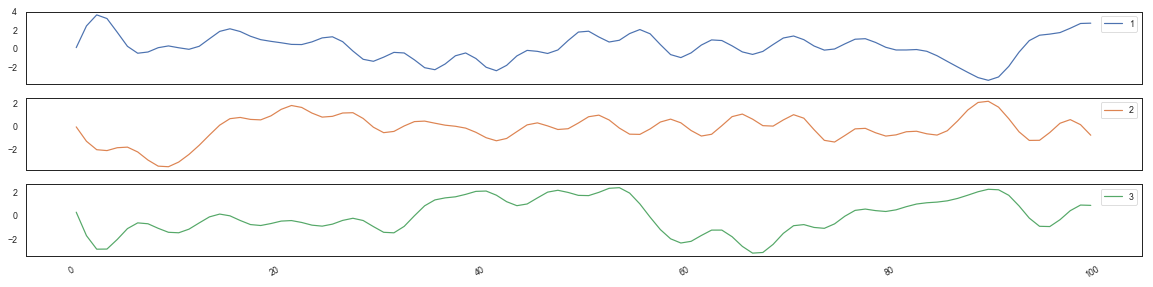

In [5]:
data.data.iloc[:100,:3].plot(figsize=(20,5), subplots=True)
plt.show()

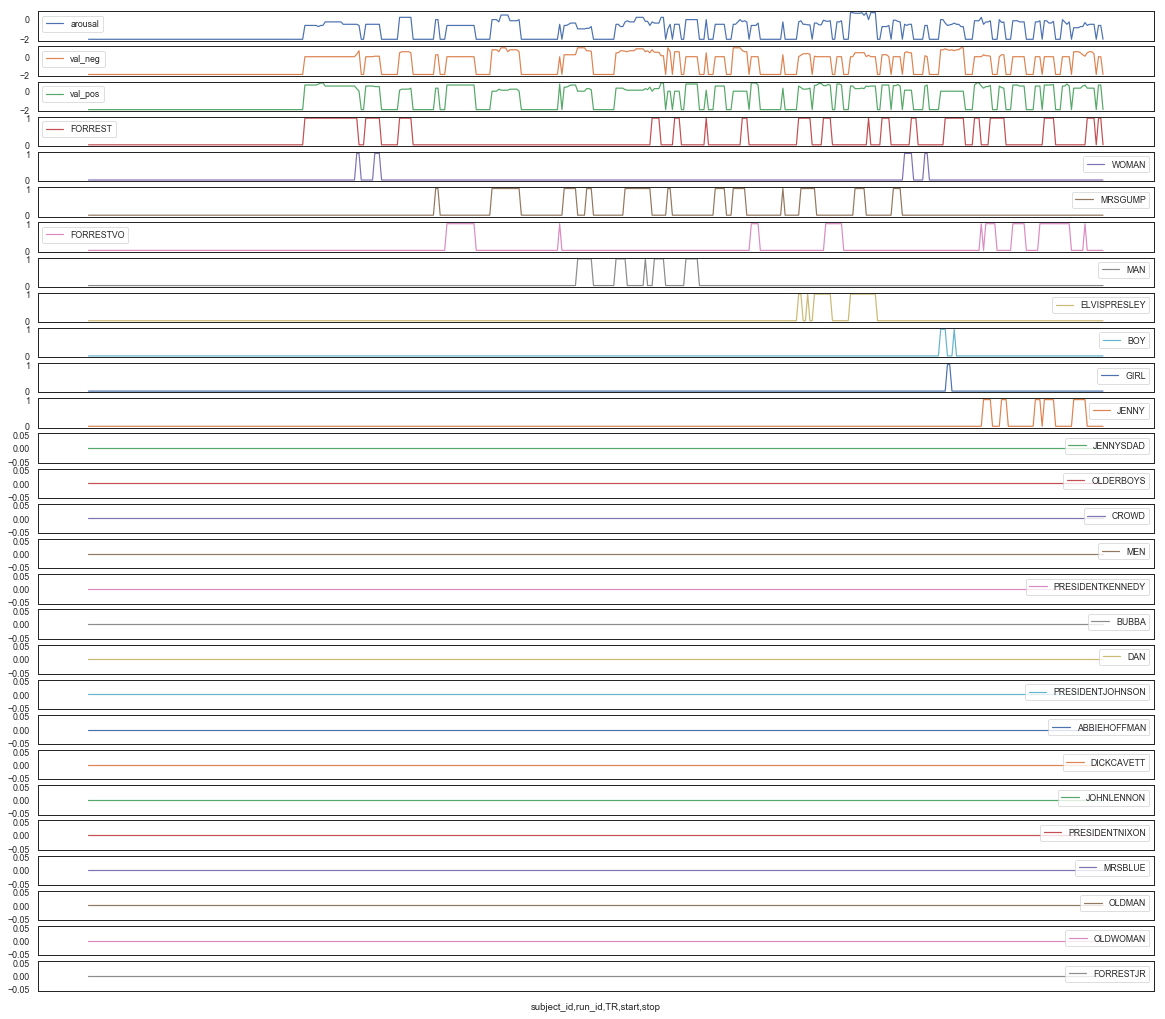

In [6]:
data.meta.plot(figsize=(20,20), subplots=True)
plt.show()

## Generate $MAPPER$ graph

In [7]:
# define inputs: X=data, y=meta
X = data.data.values
X_inverse = data.data.values

In [8]:
import kmapper as km
from sklearn.manifold import TSNE

# init MAPPER
mapper = km.KeplerMapper(verbose=1)

# init MAPPER params
projection = TSNE(perplexity=50, init='pca', random_state=0)
clusterer = km.cluster.KMeans(2)
cover = km.Cover(10, 0.5)

KeplerMapper()


In [9]:
# run MAPPER
lens = mapper.fit_transform(X, projection=projection)
graph = mapper.map(lens, X_inverse, clusterer, cover)

..Composing projection pipeline of length 1:
	Projections: TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=50,
   random_state=0, verbose=0)
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (451, 278)

..Projecting data using: 
	TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=50,
   random_state=0, verbose=1)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 451 samples in 0.002s...
[t-SNE] Computed neighbors for 451 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 451 / 451
[t-SNE] Mean sigma: 7.530325
[t-SNE] KL divergence after 250 iterations with early exaggeration: 

### Visual inspection of lens

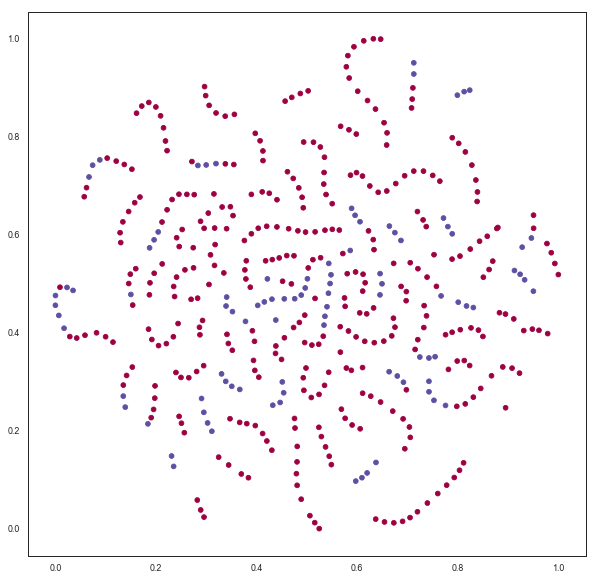

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(*lens.T, c=data.meta['FORREST'], cmap='Spectral')

## Fit a `DyNeuGraph` to the $MAPPER$ graph

Color by: 
- `arousal`
- `val_pos`
- `val_neg`
- `FORREST`


In [11]:
y_col = 'FORREST'
y = data.meta[y_col].values

# optional: define labels for legends
labels = ['n/a', 'Forrest is on screen']
print('labels:', labels)

labels: ['n/a', 'Forrest is on screen']


In [12]:
# fit DyNeuGraph to MAPPER graph
dG = ds.DyNeuGraph()
dG.fit(graph, y=y, labels=labels)

# show shape of map_ (dimensions: nodes x members)
print()
print('dG.map_:', dG.map_.shape)
print('dG.G_.graph:', dG.G_.graph)

Found 2 unique groups.
1.0

dG.map_: (451, 172)
dG.G_.graph: {'label': ['n/a', 'Forrest is on screen'], 'groups': [0, 1]}


### Visual inspection of nx.Graph object

(<matplotlib.collections.PathCollection at 0x1084ec470>,
 <matplotlib.collections.LineCollection at 0x11f3712b0>)

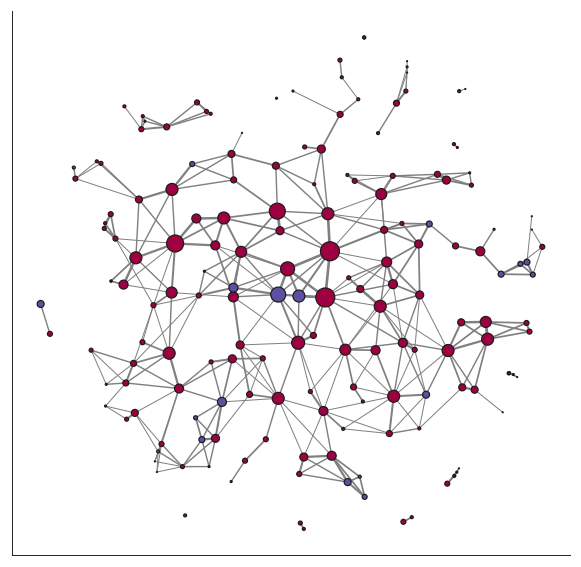

In [13]:
from collections import Counter
node_color = [Counter(y[dG.G_.nodes[n]['members']]).most_common()[0][0] for n in dG.G_]
node_size = [len(y[dG.G_.nodes[n]['members']])**2 for n in dG.G_]

# plot nx
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ds.tools.networkx_utils.draw_nx(
    dG.G_, lens=lens, pos="inverse", layout=None,
    node_size=node_size, node_color=node_color, 
    cmap='Spectral', ax=ax, 
    )

## Annotate Graph with images

In [14]:
import os
if not os.path.exists('results/tooltips'):
    os.makedirs('results/tooltips')

### Plot mean glass brain for each node

In [15]:
# use dG.G_.nodes to generate per-node SMMs
smm_images = ds.tools.mixture.simple_mixtures(
    data, mixtures=dict(dG.G_.nodes("members")),
    save_dir='results/tooltips', prefix='node_',
    print_every_n=10,
    )


/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[

[69 of 172] Saved: results/tooltips/simple_MM_node_cube41_cluster1.png
[79 of 172] Saved: results/tooltips/simple_MM_node_cube46_cluster0.png
[89 of 172] Saved: results/tooltips/simple_MM_node_cube52_cluster1.png
[99 of 172] Saved: results/tooltips/simple_MM_node_cube57_cluster1.png
[109 of 172] Saved: results/tooltips/simple_MM_node_cube62_cluster0.png
[119 of 172] Saved: results/tooltips/simple_MM_node_cube67_cluster1.png
[129 of 172] Saved: results/tooltips/simple_MM_node_cube72_cluster1.png
[139 of 172] Saved: results/tooltips/simple_MM_node_cube77_cluster1.png
[149 of 172] Saved: results/tooltips/simple_MM_node_cube82_cluster0.png
[159 of 172] Saved: results/tooltips/simple_MM_node_cube87_cluster0.png
[169 of 172] Saved: results/tooltips/simple_MM_node_cube95_cluster1.png
[done]


In [16]:
# annotate dG with images
_ = dG.annotate(image=smm_images)

### Plot Temporal Connectivity Matrix (TCM)

Saving figure, save_as: results/tcm_degree.png


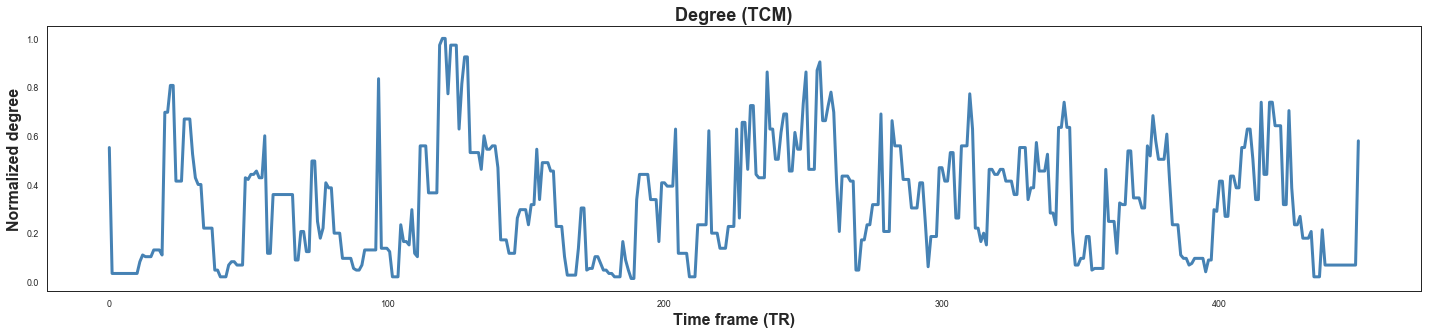

In [17]:
# plot normalized TCM
tcm_image = ds.visuals.plot_temporal_degree(
    dG.tcm_, window=1, show=True, save_as='results/tcm_degree.png'
)

In [18]:
# annotate dG with images
_ = dG.annotate(image=tcm_image)

## Visualize `DyNeuGraph`

In [19]:
%%script bash --bg

python3 -m http.server 8883

Starting job # 0 in a separate thread.


In [21]:
_ = dG.visualize('studyforrest.html', path_assets='results', show=True, PORT=8883)

0
1
[Force Graph] http://localhost:8883/studyforrest.html


<Figure size 432x288 with 0 Axes>